# What are the throughput dips at the beginning and midway through the 1:1 workloads?

In the FileStore backend objects map to files. These files are mapped onto a directory structure. To keep directories from growing too large they may be split (or merged to combine small directories). Splitting is triggered during object creation within the file store.

We modified the FileStore backend to drop a note into the Ceph logs when a split is initiated and when it completes. We plot the 1:1 bytestream appends and the start and end events. It's clear that the start and end events of splitting directories are correlated with the dips in performance.

In [23]:
import sys
import glob
import os
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import datetime
import pytz
%matplotlib inline

In [24]:
tz = pytz.timezone('America/Denver')

In [25]:
def get_start_split_trace(fn):
    events = []
    for line in open(fn):
        parts = line.split()
        if len(parts) > 5 and parts[4] == "start_split":
            date = parts[0]
            time = parts[1].split(".")[0]
            dtstr = date + " " + time
            d = datetime.datetime.strptime(dtstr, "%Y-%m-%d %H:%M:%S")
            events.append(d)
    return events

def get_finish_split_trace(fn):
    events = []
    for line in open(fn):
        parts = line.split()
        if len(parts) > 5 and parts[4] == "complete_split":
            date = parts[0]
            time = parts[1].split(".")[0]
            dtstr = date + " " + time
            d = datetime.datetime.strptime(dtstr, "%Y-%m-%d %H:%M:%S")
            events.append(d)
    return events

In [26]:
def get_client_tp_trace(fn):
    times = []
    rates = []
    for line in open(fn):
        parts = line.split()
        assert len(parts) == 5
        seconds = long(parts[2])
        rate = long(parts[3].split("=")[1])
        d = datetime.datetime.fromtimestamp(seconds, tz).replace(tzinfo=None)
        times.append(d)
        rates.append(rate)
        
    trace = pd.DataFrame({'time': times, 'iops': rates})
    
    ### order like a time series by the completion time of the I/O
    trace.sort_values(by='time', ascending=True, inplace=True)
    return trace

In [27]:
client_trace = get_client_tp_trace('bs11/client.log')
print client_trace.head()

df = pd.DataFrame({'split_start': get_start_split_trace('bs11/ceph-osd.0.log'),
                   'split_end': get_finish_split_trace('bs11/ceph-osd.0.log')})
df['y1'] = np.random.randint(19000, 21000, len(df.split_start))
df['y2'] = np.random.randint(21500, 23500, len(df.split_start))
df.sort_values(by='split_start', ascending=True, inplace=True)
df.head()

    iops                time
0  21120 2016-04-28 18:58:25
1  12742 2016-04-28 18:58:27
2  20842 2016-04-28 18:58:29
3  18579 2016-04-28 18:58:31
4  12618 2016-04-28 18:58:33


,split_end,split_start,y1,y2
0,2016-04-28 18:59:06,2016-04-28 18:59:05,19489,21789
1,2016-04-28 18:59:06,2016-04-28 18:59:06,20243,22248
2,2016-04-28 18:59:06,2016-04-28 18:59:06,20626,21720
3,2016-04-28 18:59:06,2016-04-28 18:59:06,19503,22635
4,2016-04-28 18:59:07,2016-04-28 18:59:06,20501,22809


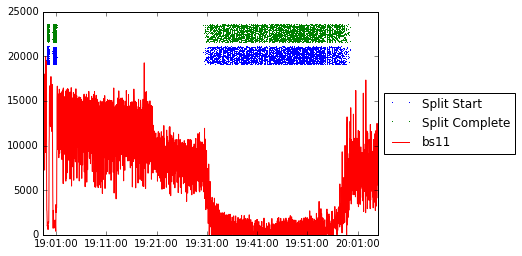

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(df.split_start, df.y1, label='Split Start', marker=',', linestyle='')
ax.plot(df.split_end, df.y2, label='Split Complete', marker=',', linestyle='')
ax.plot(client_trace.time, client_trace.iops, label="bs11")
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('x.png', dpi=300, bbox_inches='tight', bbox_extra_artists=(lgd,))

In [29]:
client_trace2 = get_client_tp_trace('kv11/kv_11_8000.log')
print client_trace2.head()

df2 = pd.DataFrame({'split_start': get_start_split_trace('kv11/ceph-osd.0.log'),
                   'split_end': get_finish_split_trace('kv11/ceph-osd.0.log')})
df2['y1'] = np.random.randint(19000, 21000, len(df.split_start))
df2['y2'] = np.random.randint(21500, 23500, len(df.split_start))
df2.sort_values(by='split_start', ascending=True, inplace=True)
df2.head()

   iops                time
0  5196 2016-04-28 22:10:35
1  4869 2016-04-28 22:10:37
2  4926 2016-04-28 22:10:39
3  4969 2016-04-28 22:10:41
4  4935 2016-04-28 22:10:43


,split_end,split_start,y1,y2
0,2016-04-28 22:12:52,2016-04-28 22:12:52,20374,23095
1,2016-04-28 22:12:52,2016-04-28 22:12:52,19923,22727
2,2016-04-28 22:12:53,2016-04-28 22:12:53,20022,22536
3,2016-04-28 22:12:53,2016-04-28 22:12:53,19315,21737
4,2016-04-28 22:12:54,2016-04-28 22:12:54,20803,22500


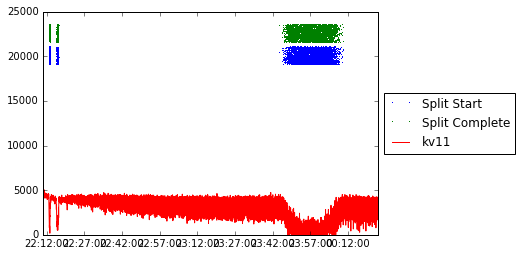

In [30]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(df2.split_start, df.y1, label='Split Start', marker=',', linestyle='')
ax.plot(df2.split_end, df.y2, label='Split Complete', marker=',', linestyle='')
ax.plot(client_trace2.time, client_trace2.iops, label='kv11')
lgd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('x.png', dpi=300, bbox_inches='tight', bbox_extra_artists=(lgd,))